In [ ]:
# Bayesian competitor model 

import random
import numpy as np
import pandas as pd

# Reproducibility
np.random.seed(42)
random.seed(42)

# Global decision threshold (Stag iff p > 2/3)

P_THRESHOLD = 2.0 / 3.0


# Partner strategies that DO NOT depend on the agent
# (identical behavior to originals)

def always_collaborate():
    return 1

def always_defect():
    return 0

def random_strategy():
    return random.choice([0, 1])

def cheating_partner(round_num, cycle_length=6, cheat_duration=2):
    # cooperate for cycle_length rounds, then defect for cheat_duration rounds (repeating)
    return 1 if (round_num % (cycle_length + cheat_duration)) < cycle_length else 0

def cheating_partner_cycle(round_num, cycle_length_1=30):
    # cooperate for cycle_length rounds, then defect for cheat_duration rounds (repeating)
    return 1 if (round_num < cycle_length_1) else 0

def probabilistic_cheater(p_coop=0.7):
    return 1 if random.random() < p_coop else 0

def tit_for_tat_cooperate(last_agent_choice=1):
    # TFT with cooperative seed
    return last_agent_choice

def tit_for_tat_defect(last_agent_choice=0):
    # TFT with defective seed
    return last_agent_choice

# These mirror our originals that read agent.x / agent.t
# Here, they read directly from the Bayesian agent.

def adaptive_strategy_bayes(bayes_agent):
    """
    Cooperate iff the agent's current expectation of partner cooperation is > 0.5.
    In Bayes, use posterior mean as the expectation proxy.
    """
    return 1 if bayes_agent.posterior_mean > 0.5 else 0

def strategic_cheater_bayes(bayes_agent, t_threshold=2.5):
    """
    Defect when the agent's 'confidence' is high. In Bayes, use concentration = alpha+beta-2.
    """
    return 0 if bayes_agent.concentration > t_threshold else 1

def expectation_violation_cheater_bayes(bayes_agent):
    """
    Choose the opposite of what the agent 'expects' (here, whether posterior_mean > 0.5).
    """
    return 0 if bayes_agent.posterior_mean > 0.5 else 1

# Bayesian Agent (stationary Beta-Binomial)

class BayesianAgent:
    """
    Stationary Beta–Binomial learner for the partner's cooperation probability.
    Decision: play Stag iff posterior mean > 2/3.
    Prior aligned with dual-state initialization via x0,T0:
      alpha0 = 1 + x0*T0, beta0 = 1 + (1-x0)*T0  (defaults: x0=1/3, T0=1.0)
    """
    def __init__(self, alpha0=None, beta0=None, x0=1/3, T0=1.0):
        if alpha0 is None or beta0 is None:
            alpha0 = 1 + x0 * T0
            beta0  = 1 + (1 - x0) * T0
        self.alpha = float(alpha0)
        self.beta  = float(beta0)

    @property
    def posterior_mean(self):
        return self.alpha / (self.alpha + self.beta)

    @property
    def concentration(self):
        # Evidence strength proxy analogous to "trust" scale
        return self.alpha + self.beta - 2.0

    def make_decision(self):
        return 1 if self.posterior_mean > P_THRESHOLD else 0

    def update(self, partner_choice):
        # partner_choice: 1=cooperate (Stag), 0=defect (Hare)
        self.alpha += partner_choice
        self.beta  += (1 - partner_choice)

# Simulation harness (no shim; handles different policy signatures)

def run_bayesian_simulation(
    num_rounds=70,
    strategy="always_collaborate",
    initial_last_choice=1,
    strategy_kwargs=None,
    prior_alpha=None,
    prior_beta=None,
    x0=1/3,
    T0=1.0
):
    """
    Runs the Bayesian baseline against a given partner strategy.

    strategy: one of the following strings:
      - 'always_collaborate', 'always_defect', 'random', 
        'probabilistic_cheater', 'cheating_partner',
        'tft_cooperate', 'tft_defect',
        'adaptive_bayes', 'strategic_cheater_bayes', 'expectation_violation_bayes'

    Returns DataFrame with columns:
      Round, Agent_Choice, Partner_Choice, Posterior_Mean, Alpha, Beta, Concentration
    """
    if strategy_kwargs is None:
        strategy_kwargs = {}

    agent = BayesianAgent(alpha0=prior_alpha, beta0=prior_beta, x0=x0, T0=T0)

    results = []
    last_agent_choice = initial_last_choice

    for round_num in range(num_rounds):
        # Agent decision (based on current posterior mean)
        agent_choice = agent.make_decision()

        # Partner move based on selected policy
        if strategy == "always_collaborate":
            partner_choice = always_collaborate()

        elif strategy == "always_defect":
            partner_choice = always_defect()

        elif strategy == "random":
            partner_choice = random_strategy()

        elif strategy == "probabilistic_cheater":
            p = strategy_kwargs.get("p_coop", 0.7)
            partner_choice = probabilistic_cheater(p_coop=p)

        elif strategy == "cheating_partner":
            cyc = strategy_kwargs.get("cycle_length", 6)
            dur = strategy_kwargs.get("cheat_duration", 2)
            partner_choice = cheating_partner(round_num, cycle_length=cyc, cheat_duration=dur)

        elif strategy == "cheating_partner_cycle":
            partner_choice = cheating_partner_cycle(round_num, cycle_length_1=30)

        elif strategy == "tft_cooperate":
            partner_choice = tit_for_tat_cooperate(last_agent_choice=last_agent_choice)

        elif strategy == "tft_defect":
            partner_choice = tit_for_tat_defect(last_agent_choice=last_agent_choice)

        elif strategy == "adaptive_bayes":
            partner_choice = adaptive_strategy_bayes(agent)

        elif strategy == "strategic_cheater_bayes":
            thr = strategy_kwargs.get("t_threshold", 2.5)
            partner_choice = strategic_cheater_bayes(agent, t_threshold=thr)

        elif strategy == "expectation_violation_bayes":
            partner_choice = expectation_violation_cheater_bayes(agent)

        else:
            raise ValueError(f"Unknown strategy: {strategy}")

        # Update posterior
        agent.update(partner_choice)

        # TFT state update
        last_agent_choice = agent_choice

        # Log
        results.append((
            round_num + 1,
            agent_choice,
            partner_choice,
            agent.posterior_mean,
            agent.alpha,
            agent.beta,
            agent.concentration
        ))

    return pd.DataFrame(results, columns=[
        "Round", "Agent_Choice", "Partner_Choice", "Posterior_Mean", "Alpha", "Beta", "Concentration"
    ])

# -------------------------
# Example runs (parallel to current experiments)
# -------------------------
if __name__ == "__main__":
    num_rounds = 70

    df_bayes_collab    = run_bayesian_simulation(num_rounds, "always_collaborate")
    df_bayes_defect    = run_bayesian_simulation(num_rounds, "always_defect")
    df_bayes_random    = run_bayesian_simulation(num_rounds, "random")
    df_bayes_prob      = run_bayesian_simulation(num_rounds, "probabilistic_cheater", strategy_kwargs={"p_coop": 0.7})
    df_bayes_cheating  = run_bayesian_simulation(num_rounds, "cheating_partner", strategy_kwargs={"cycle_length": 4, "cheat_duration": 2})
    df_bayes_cheating_partner_cycle = run_bayesian_simulation(num_rounds, "cheating_partner_cycle", strategy_kwargs={"cycle_length_1": 30})
    df_bayes_tft_c     = run_bayesian_simulation(num_rounds, "tft_cooperate", initial_last_choice=1)
    df_bayes_tft_d     = run_bayesian_simulation(num_rounds, "tft_defect", initial_last_choice=0)
    df_bayes_adaptive  = run_bayesian_simulation(num_rounds, "adaptive_bayes")
    df_bayes_strat     = run_bayesian_simulation(num_rounds, "strategic_cheater_bayes", strategy_kwargs={"t_threshold": 2.5})
    df_bayes_expect    = run_bayesian_simulation(num_rounds, "expectation_violation_bayes")

    # Quick sanity check
    # print(df_bayes_collab.head())


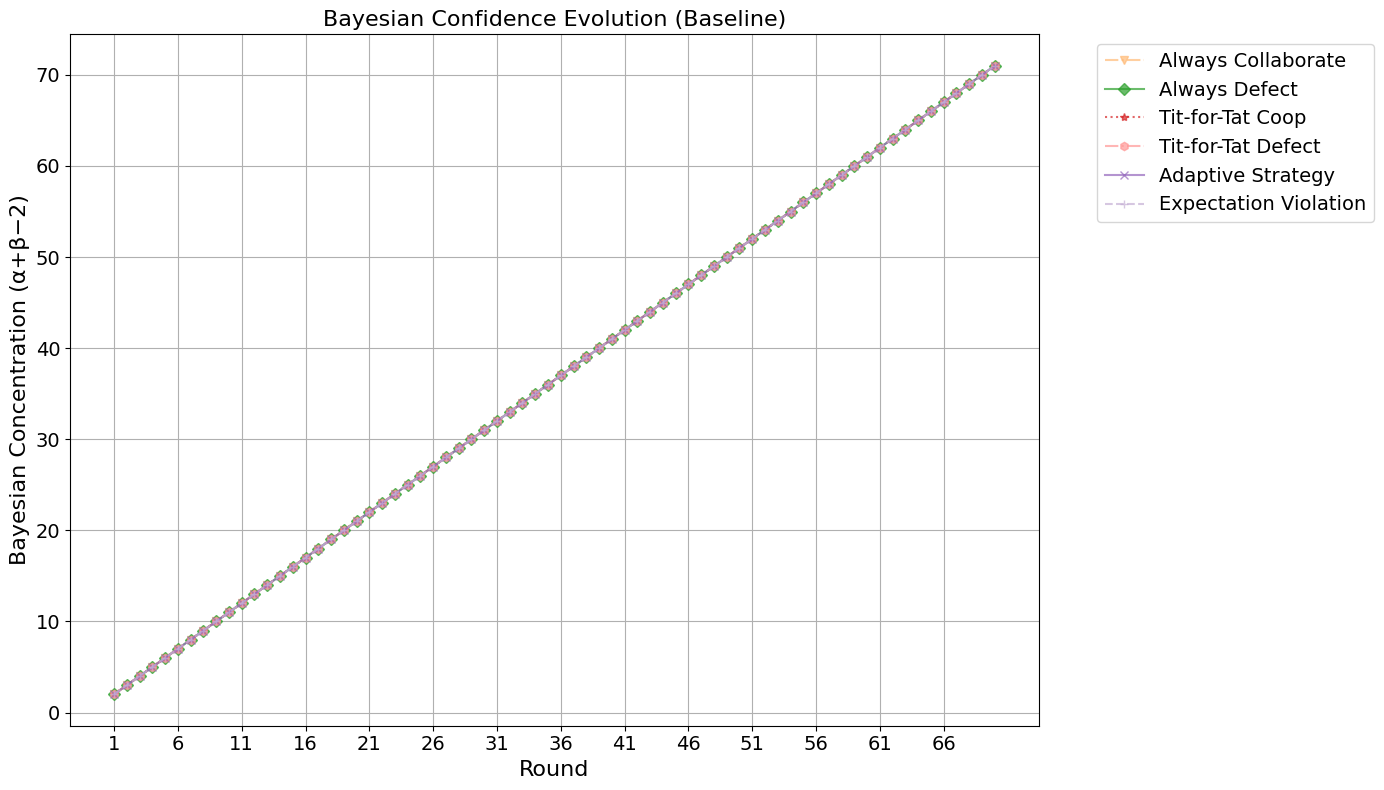

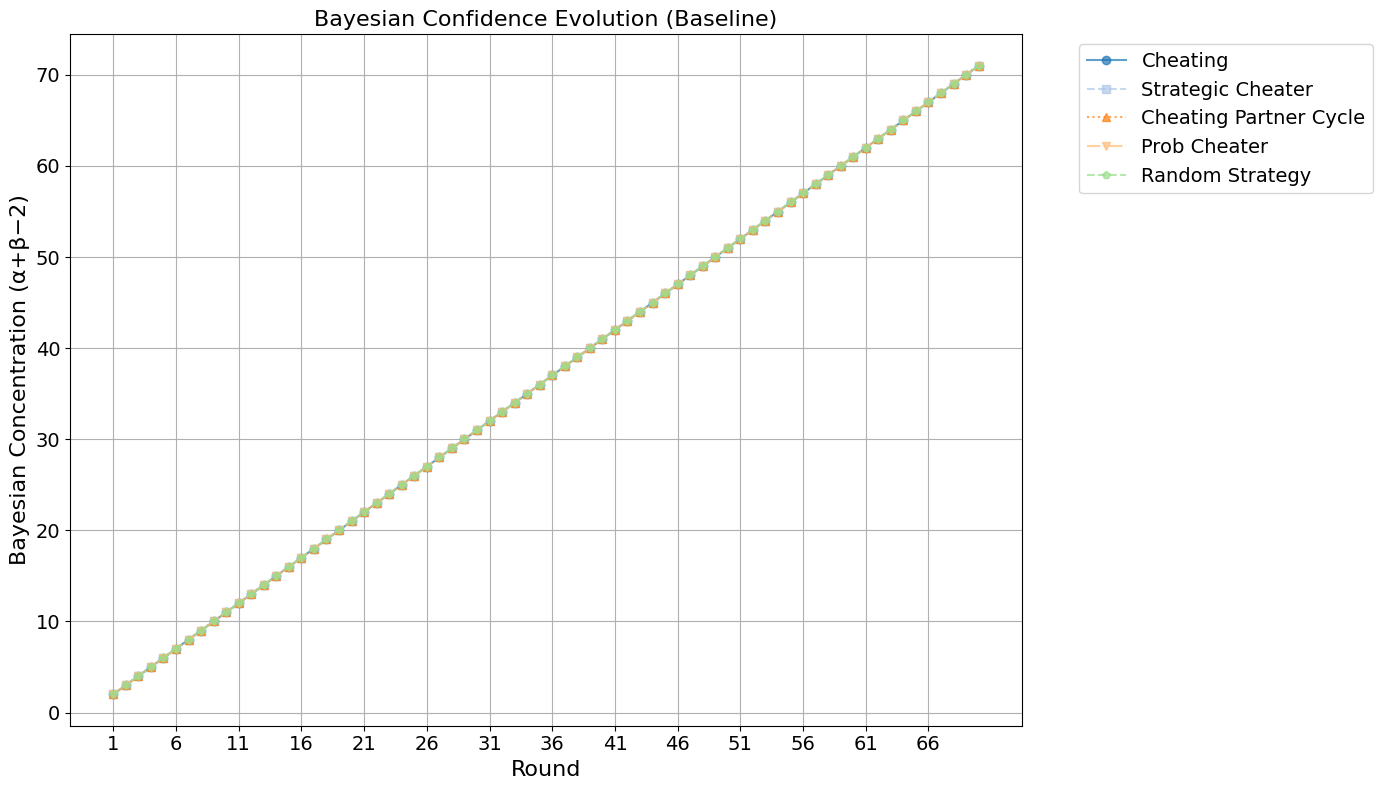

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# same palette and styles you used
colors = sns.color_palette("tab20", 10)
line_styles = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'x', '+']

# ---------- Confidence/Trust Evolution: cooperative-ish set ----------
plt.figure(figsize=(14, 8))
plt.plot(df_bayes_collab["Round"], df_bayes_collab["Concentration"], label="Always Collaborate",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)

plt.plot(df_bayes_defect["Round"], df_bayes_defect["Concentration"], label="Always Defect",
         color=colors[4], linestyle=line_styles[4], marker=markers[4], alpha=0.7)

plt.plot(df_bayes_tft_c["Round"], df_bayes_tft_c["Concentration"], label="Tit-for-Tat Coop",
         color=colors[6], linestyle=line_styles[6], marker=markers[6], alpha=0.7)

plt.plot(df_bayes_tft_d["Round"], df_bayes_tft_d["Concentration"], label="Tit-for-Tat Defect",
         color=colors[7], linestyle=line_styles[7], marker=markers[7], alpha=0.7)

plt.plot(df_bayes_adaptive["Round"], df_bayes_adaptive["Concentration"], label="Adaptive Strategy",
         color=colors[8], linestyle=line_styles[8], marker=markers[8], alpha=0.7)

plt.plot(df_bayes_expect["Round"], df_bayes_expect["Concentration"], label="Expectation Violation",
         color=colors[9], linestyle=line_styles[9], marker=markers[9], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Bayesian Concentration (α+β−2)", fontsize=16)
plt.title("Bayesian Confidence Evolution (Baseline)", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# ---------- Confidence/Trust Evolution: adversarial/noisy set ----------
plt.figure(figsize=(14, 8))
plt.plot(df_bayes_cheating["Round"], df_bayes_cheating["Concentration"], label="Cheating",
         color=colors[0], linestyle=line_styles[0], marker=markers[0], alpha=0.7)

plt.plot(df_bayes_strat["Round"], df_bayes_strat["Concentration"], label="Strategic Cheater",
         color=colors[1], linestyle=line_styles[1], marker=markers[1], alpha=0.7)

plt.plot(df_bayes_cheating_partner_cycle["Round"], df_bayes_cheating_partner_cycle["Concentration"], label="Cheating Partner Cycle",
         color=colors[2], linestyle=line_styles[2], marker=markers[2], alpha=0.7)

plt.plot(df_bayes_prob["Round"], df_bayes_prob["Concentration"], label="Prob Cheater",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)

plt.plot(df_bayes_random["Round"], df_bayes_random["Concentration"], label="Random Strategy",
         color=colors[5], linestyle=line_styles[5], marker=markers[5], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Bayesian Concentration (α+β−2)", fontsize=16)
plt.title("Bayesian Confidence Evolution (Baseline)", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


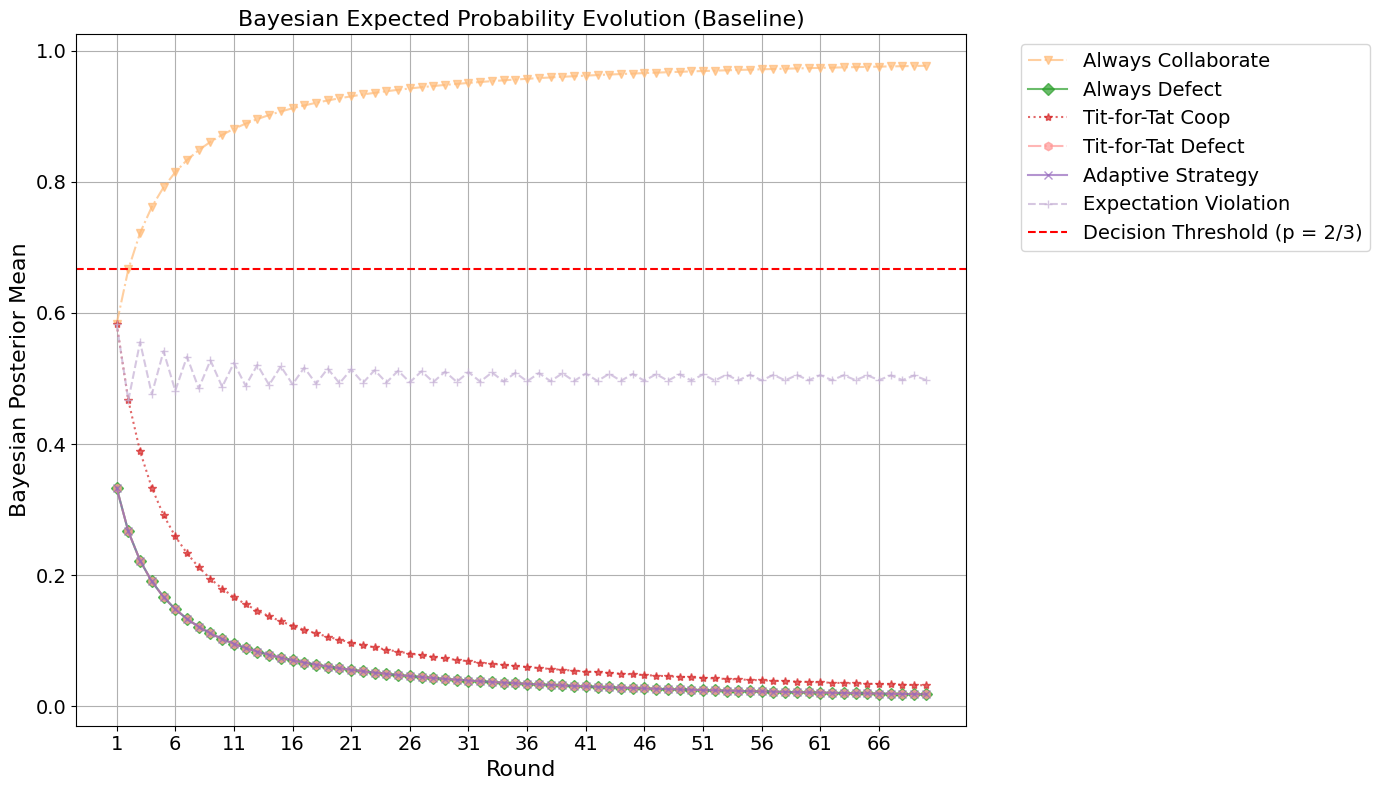

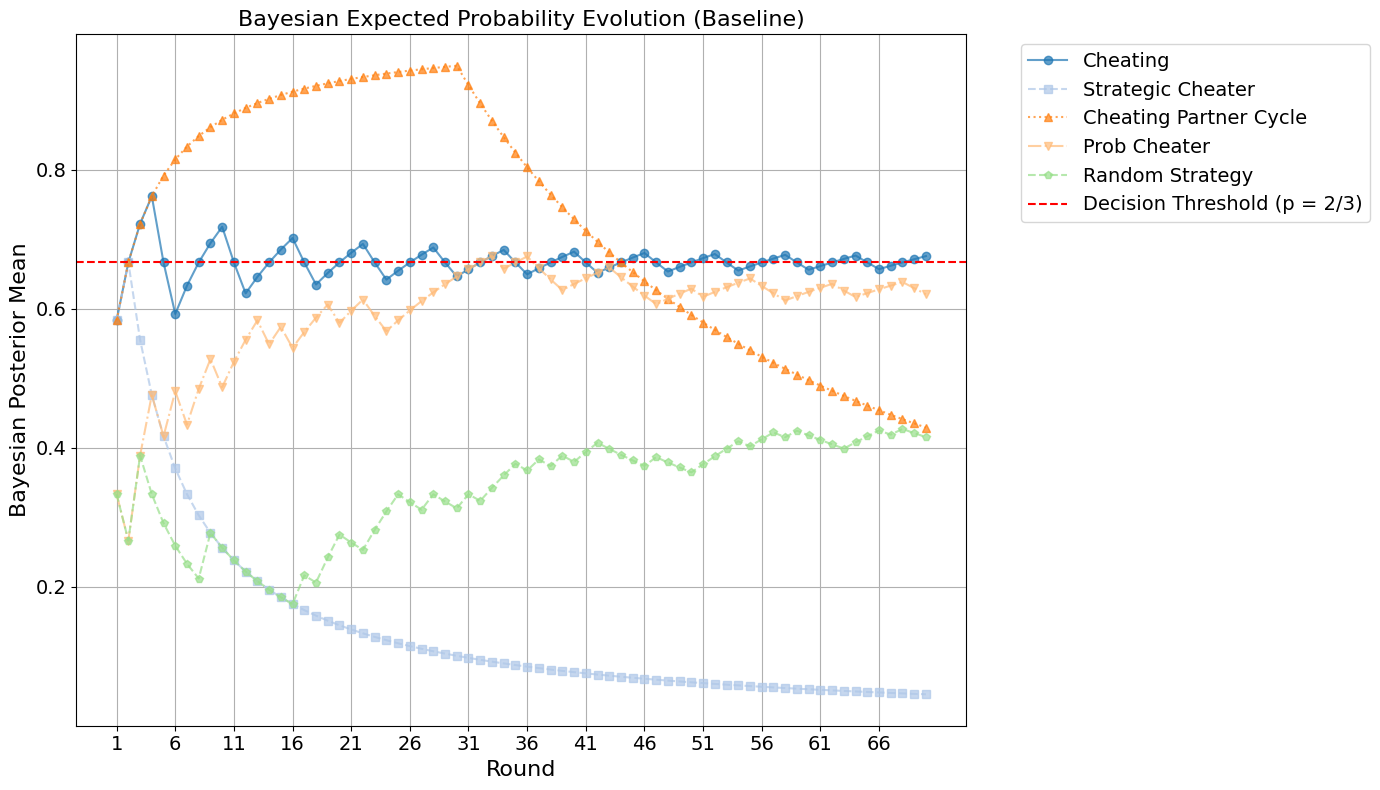

In [17]:
# ---------- Expected Probability (Bayes) Evolution: cooperative-ish set ----------
plt.figure(figsize=(14, 8))
plt.plot(df_bayes_collab["Round"], df_bayes_collab["Posterior_Mean"], label="Always Collaborate",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)

plt.plot(df_bayes_defect["Round"], df_bayes_defect["Posterior_Mean"], label="Always Defect",
         color=colors[4], linestyle=line_styles[4], marker=markers[4], alpha=0.7)

plt.plot(df_bayes_tft_c["Round"], df_bayes_tft_c["Posterior_Mean"], label="Tit-for-Tat Coop",
         color=colors[6], linestyle=line_styles[6], marker=markers[6], alpha=0.7)

plt.plot(df_bayes_tft_d["Round"], df_bayes_tft_d["Posterior_Mean"], label="Tit-for-Tat Defect",
         color=colors[7], linestyle=line_styles[7], marker=markers[7], alpha=0.7)

plt.plot(df_bayes_adaptive["Round"], df_bayes_adaptive["Posterior_Mean"], label="Adaptive Strategy",
         color=colors[8], linestyle=line_styles[8], marker=markers[8], alpha=0.7)

plt.plot(df_bayes_expect["Round"], df_bayes_expect["Posterior_Mean"], label="Expectation Violation",
         color=colors[9], linestyle=line_styles[9], marker=markers[9], alpha=0.7)

plt.axhline(2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')
plt.xlabel("Round", fontsize=16)
plt.ylabel("Bayesian Posterior Mean", fontsize=16)
plt.title("Bayesian Expected Probability Evolution (Baseline)", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# ---------- Expected Probability (Bayes) Evolution: adversarial/noisy set ----------
plt.figure(figsize=(14, 8))
plt.plot(df_bayes_cheating["Round"], df_bayes_cheating["Posterior_Mean"], label="Cheating",
         color=colors[0], linestyle=line_styles[0], marker=markers[0], alpha=0.7)
plt.plot(df_bayes_strat["Round"], df_bayes_strat["Posterior_Mean"], label="Strategic Cheater",
         color=colors[1], linestyle=line_styles[1], marker=markers[1], alpha=0.7)
plt.plot(df_bayes_cheating_partner_cycle["Round"], df_bayes_cheating_partner_cycle["Posterior_Mean"], label="Cheating Partner Cycle",
         color=colors[2], linestyle=line_styles[2], marker=markers[2], alpha=0.7)
plt.plot(df_bayes_prob["Round"], df_bayes_prob["Posterior_Mean"], label="Prob Cheater",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)
plt.plot(df_bayes_random["Round"], df_bayes_random["Posterior_Mean"], label="Random Strategy",
         color=colors[5], linestyle=line_styles[5], marker=markers[5], alpha=0.7)

plt.axhline(2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')
plt.xlabel("Round", fontsize=16)
plt.ylabel("Bayesian Posterior Mean", fontsize=16)
plt.title("Bayesian Expected Probability Evolution (Baseline)", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


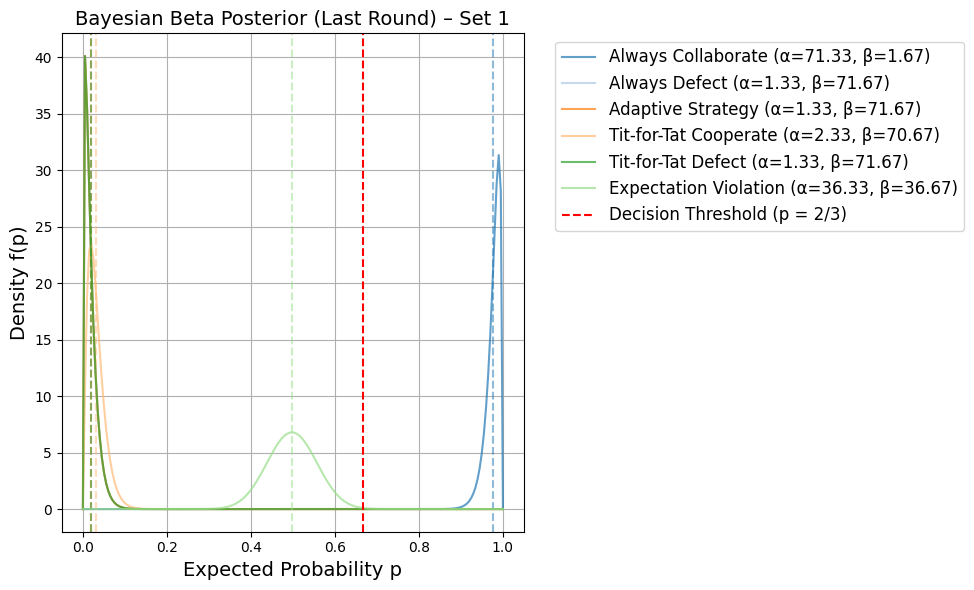

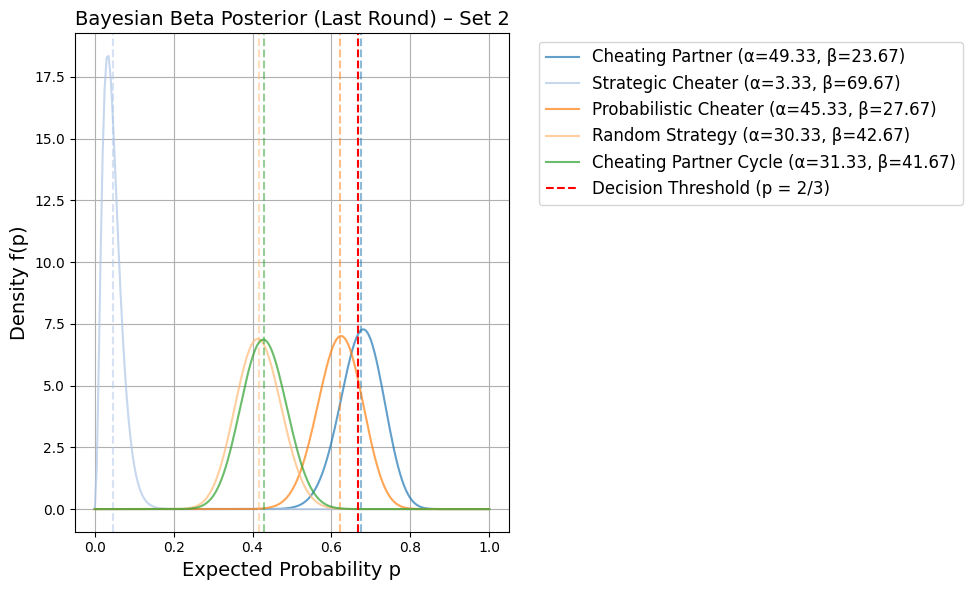

In [18]:
from scipy import stats

# Pick the same sets you used earlier
strategies_bayes_1 = [
    ("Always Collaborate", df_bayes_collab),
    ("Always Defect", df_bayes_defect),
    ("Adaptive Strategy", df_bayes_adaptive),
    ("Tit-for-Tat Cooperate", df_bayes_tft_c),
    ("Tit-for-Tat Defect", df_bayes_tft_d),
    ("Expectation Violation", df_bayes_expect)
]

# --- Plot Beta PDFs for set 1 ---
p = np.linspace(0, 1, 200)
plt.figure(figsize=(10, 6))
colors = sns.color_palette("tab20", 10)

for idx, (name, dfb) in enumerate(strategies_bayes_1):
    last = dfb.iloc[-1]
    alpha, beta = last["Alpha"], last["Beta"]
    # Posterior mean (vertical line)
    E_p = last["Posterior_Mean"]
    plt.plot(p, stats.beta.pdf(p, alpha, beta),
             label=f"{name} (α={alpha:.2f}, β={beta:.2f})",
             alpha=0.7, color=colors[idx])
    plt.axvline(x=E_p, linestyle='--', alpha=0.5, color=colors[idx])

plt.axvline(x=2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')
plt.xlabel("Expected Probability p", fontsize=14)
plt.ylabel("Density f(p)", fontsize=14)
plt.title("Bayesian Beta Posterior (Last Round) – Set 1", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# --- Plot Beta PDFs for set 2 (adversarial/noisy) ---
strategies_bayes_2 = [
    ("Cheating Partner", df_bayes_cheating),
    ("Strategic Cheater", df_bayes_strat),
    ("Probabilistic Cheater", df_bayes_prob),
    ("Random Strategy", df_bayes_random),
    ("Cheating Partner Cycle", df_bayes_cheating_partner_cycle)
]

plt.figure(figsize=(10, 6))
for idx, (name, dfb) in enumerate(strategies_bayes_2):
    last = dfb.iloc[-1]
    alpha, beta = last["Alpha"], last["Beta"]
    E_p = last["Posterior_Mean"]
    plt.plot(p, stats.beta.pdf(p, alpha, beta),
             label=f"{name} (α={alpha:.2f}, β={beta:.2f})",
             alpha=0.7, color=colors[idx])
    plt.axvline(x=E_p, linestyle='--', alpha=0.5, color=colors[idx])

plt.axvline(x=2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')
plt.xlabel("Expected Probability p", fontsize=14)
plt.ylabel("Density f(p)", fontsize=14)
plt.title("Bayesian Beta Posterior (Last Round) – Set 2", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()


In [19]:
print("Bayesian – Decision-Making Trends in the Last Round:")
for name, dfb in strategies_bayes_1:
    last = dfb.iloc[-1]
    last_choice = last["Agent_Choice"]
    last_p = last["Posterior_Mean"]
    print(f"{name}: p = {last_p:.3f}, Choice = {'Stag' if last_choice == 1 else 'Hare'}")

for name, dfb in strategies_bayes_2:
    last = dfb.iloc[-1]
    last_choice = last["Agent_Choice"]
    last_p = last["Posterior_Mean"]
    print(f"{name}: p = {last_p:.3f}, Choice = {'Stag' if last_choice == 1 else 'Hare'}")


Bayesian – Decision-Making Trends in the Last Round:
Always Collaborate: p = 0.977, Choice = Stag
Always Defect: p = 0.018, Choice = Hare
Adaptive Strategy: p = 0.018, Choice = Hare
Tit-for-Tat Cooperate: p = 0.032, Choice = Hare
Tit-for-Tat Defect: p = 0.018, Choice = Hare
Expectation Violation: p = 0.498, Choice = Hare
Cheating Partner: p = 0.676, Choice = Stag
Strategic Cheater: p = 0.046, Choice = Hare
Probabilistic Cheater: p = 0.621, Choice = Hare
Random Strategy: p = 0.416, Choice = Hare
Cheating Partner Cycle: p = 0.429, Choice = Hare
